<h1><center>EE69210: Machine Learning for Signal Processing Laboratory</center></h1>
<h2><center>Experiment-3: Bayes' Classifier</center></h2>
<h3><center>Anirvan Krishna | 21EE38002</center></h3>

In [1]:
import IPython.display as display
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from seglearn.transform import Segment
%config InlineBackend.figure_format="svg"

from sklearn.utils import shuffle
from scipy.fft import dct , idct
from sklearn.decomposition import PCA

In [2]:
sample_audio = 'the_godfather_theme_instru_mix.wav'
x, sr = librosa.load(sample_audio, sr=44100)

In [3]:
x_v = x[:sr*30]
x_g = x[sr*30:sr*60]

X = np.stack((x_v , x_g))
y = np.array ([0 , 1])
samples_per_frame = int(sr * 0.02)

In [4]:
ts = Segment(width=samples_per_frame ,overlap=0).fit(X, y)
s_d = ts.transform(X, y)

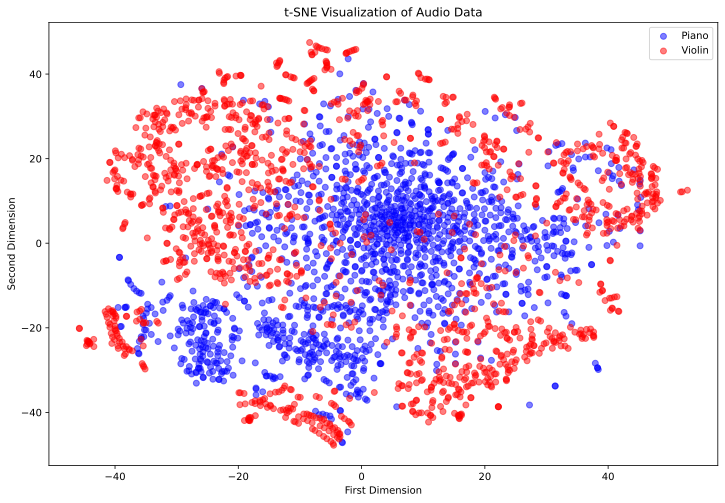

In [5]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Standardize the feature matrix
scaler = StandardScaler()
x_tsne_train = scaler.fit_transform(s_d[0])

model = TSNE(n_components=2, random_state=42)
X_tsne = model.fit_transform(x_tsne_train)

# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[s_d[1] == 0][:, 0], X_tsne[s_d[1] == 0]
            [:, 1], c='blue', label='Piano', alpha=0.5)
plt.scatter(X_tsne[s_d[1] == 1][:, 0], X_tsne[s_d[1] == 1]
            [:, 1], c='red', label='Violin', alpha=0.5)
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('t-SNE Visualization of Audio Data')
plt.legend()
plt.show()

## DCT Based Feature Extraction

Discrete Cosine Transform (DCT) is used to convert a signal into its constituent frequencies. For a signal $ x[n] $, the DCT is defined as:

$$ X[k] = \sum_{n=0}^{N-1} x[n] \cos \left( \frac{\pi}{N} \left( n + \frac{1}{2} \right) k \right) $$

The frequency corresponding to the k-th component can be calculated using the formula:

$$ f[k] = \frac{k \cdot sr}{N} $$

where $ sr $ is the sampling rate and $ N $ is the number of samples.

Size of generated feature vector: (2, 1323000)


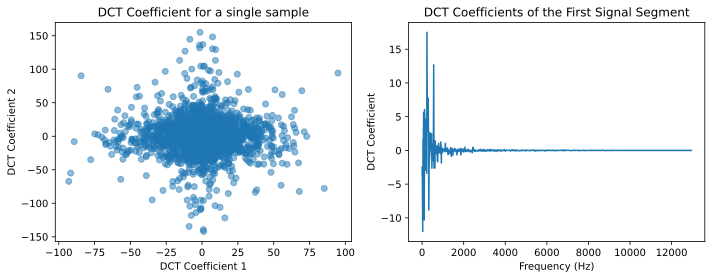

In [6]:
# Compute DCT
X_dct = dct(s_d[0])

print("Size of generated feature vector:", X.shape)

# Create a figure with 2 subplots in a single row
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# First subplot - scatter plot
ax1.scatter(X_dct[:, 0], X_dct[:, 1], alpha=0.5)
ax1.set_xlabel('DCT Coefficient 1')  
ax1.set_ylabel('DCT Coefficient 2')
ax1.set_title('DCT Coefficient for a single sample')

# Second subplot - frequency plot
f = [k*sr/len(s_d[0]) for k in range(len(X_dct[0]))]
ax2.plot(f, X_dct[0])
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('DCT Coefficient')
ax2.set_title('DCT Coefficients of the First Signal Segment')

plt.tight_layout()
plt.show()

## Preparation of training set

In [7]:
x_train , y_train = X_dct , s_d[1]
x_train , y_train = shuffle(x_train , y_train , random_state=42)

## Functions for inference

In [8]:
def mahalanobis(x, mu, sigma):
    x_minus_mu = x - mu
    inv_sigma = np.linalg.inv(sigma)
    left_term = np.dot(x_minus_mu, inv_sigma)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal

def likelihood(x, mu, sigma):
    
    # Calculate the Mahalanobis distance
    mahal = mahalanobis(x, mu, sigma)

    # Calculate the likelihood
    likelihood = np.exp(-0.5 * mahal) / (((2*np.pi)**(sigma.shape[0]/2)) * np.sqrt(np.linalg.det(sigma)))   

    return likelihood

In [9]:
def predict(x, prior0, prior1, mu0, mu1, sigma0, sigma1):

    # Calculate the likelihoods for each class
    likelihood0 = likelihood(x, mu0, sigma0)
    likelihood1 = likelihood(x, mu1, sigma1)
    
    # Calculate the posterior probabilities
    posterior0 = (likelihood0 * prior0) / (likelihood0 * prior0 + likelihood1 * prior1)
    posterior1 = (likelihood1 * prior1) / (likelihood0 * prior0 + likelihood1 * prior1)
    
    # Assign the class label based on the posterior probabilities
    return (posterior1 > posterior0)

In [10]:
x0 = x_train[y_train == 0]
x1 = x_train[y_train == 1]

mu_x0 = np.mean(x0, axis=0)
mu_x1 = np.mean(x1, axis=0)

Rx0 = np.cov(x0.T)
Rx1 = np.cov(x1.T)

prior0 = len(x0) / len(x_train)
prior1 = len(x1) / len(x_train)

print(f"Mean vector for class 0: {mu_x0.shape}")
print(f"Mean vector for class 1: {mu_x1.shape}\n")
print(f"Covariance Matrix for class 0: {Rx0.shape}")
print(f"Covariance Matrix for class 1: {Rx1.shape}\n")
print(f"Prior probability for class 0: {prior0}")
print(f"Prior probability for class 1: {prior1}")

Mean vector for class 0: (882,)
Mean vector for class 1: (882,)

Covariance Matrix for class 0: (882, 882)
Covariance Matrix for class 1: (882, 882)

Prior probability for class 0: 0.5
Prior probability for class 1: 0.5


In [11]:
# Check if covariance matrices are singular
det_rx0 = np.linalg.det(Rx0)
det_rx1 = np.linalg.det(Rx1)

print("Determinant of covariance matrix for class 0:", det_rx0)
print("Determinant of covariance matrix for class 1:", det_rx1)

if det_rx0 == 0 or det_rx1 == 0:
    
    print("\nCovariance matrices are singular. Need to apply PCA.")
    
    # Get variance preservation ratio from user
    var_ratio = float(input("Enter variance preservation ratio (between 0 and 1): "))
    
    # Apply PCA
    pca = PCA(n_components=var_ratio, svd_solver='full')  # Automatically determines the number of components
    x_train_pca = pca.fit_transform(x_train)
    
    # Recalculate means and covariances with reduced dimensions
    x0_pca = x_train_pca[y_train == 0]
    x1_pca = x_train_pca[y_train == 1]
    
    mu_x0_pca = np.mean(x0_pca, axis=0) 
    mu_x1_pca = np.mean(x1_pca, axis=0)
    
    Rx0_pca = np.cov(x0_pca.T)
    Rx1_pca = np.cov(x1_pca.T)
    
    print(f"\nAfter PCA:")
    print(f"Number of components selected: {pca.n_components_}")
    print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")
    print(f"New feature dimensions: {x_train_pca.shape[1]}")

Determinant of covariance matrix for class 0: 0.0
Determinant of covariance matrix for class 1: 0.0

Covariance matrices are singular. Need to apply PCA.

After PCA:
Number of components selected: 102
Explained variance ratio: 0.9951
New feature dimensions: 102


### Performance on the training data

In [12]:
# Predict the class of the samples
y_pred = np.zeros(x_train_pca.shape[0])

for i in range(x_train_pca.shape[0]):
    y_pred[i] = predict(x_train_pca[i], prior0, prior1, mu_x0_pca, mu_x1_pca, Rx0_pca, Rx1_pca)

y_pred

array([1., 0., 1., ..., 0., 0., 0.])

### Performance on training set

Accuracy of the classifier: 0.9743


              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1500
           1       0.96      0.99      0.97      1500

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



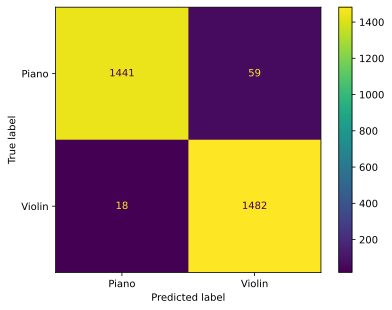

In [13]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy of the classifier: {accuracy:.4f}\n\n")

# Display the classification report
print(classification_report(y_train, y_pred))

# Display the confusion matrix
cm = confusion_matrix(y_train, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Piano', 'Violin']).plot()

# Inference on the test set

## Preparation of the test set and DCT features

In [14]:
sample_audio_test = 'the_godfather_theme_test.wav'
x_test, sr = librosa.load(sample_audio_test, sr=44100)

ts_test = Segment(width=samples_per_frame, overlap=0).fit(x_test.reshape(1, -1))

s_d_test = ts_test.transform(x_test.reshape(1, -1))

print('Size of one Vector:', s_d_test[0].shape[1])
print('Number of Test Vectors:', s_d_test[0].shape[0])

Size of one Vector: 882
Number of Test Vectors: 1500


In [15]:
X_d_test = dct(s_d_test[0])
x_test = pca.transform(X_d_test)
y_test = np.concatenate((np.ones(750), np.zeros(750))) # First half 1s and 2nd half 0, opposite to X_train

In [16]:
x_test.shape

(1500, 102)

In [17]:
# Predict the class of the samples
y_pred = np.zeros(x_test.shape[0])

for i in range(x_test.shape[0]):
    y_pred[i] = predict(x_test[i], prior0, prior1,
                        mu_x0_pca, mu_x1_pca, Rx0_pca, Rx1_pca)

y_pred

C:\Users\Anirvan Krishna\AppData\Local\Temp\ipykernel_23952\816245241.py:8: RuntimeWarning: invalid value encountered in scalar divide
  posterior0 = (likelihood0 * prior0) / (likelihood0 * prior0 + likelihood1 * prior1)
C:\Users\Anirvan Krishna\AppData\Local\Temp\ipykernel_23952\816245241.py:9: RuntimeWarning: invalid value encountered in scalar divide
  posterior1 = (likelihood1 * prior1) / (likelihood0 * prior0 + likelihood1 * prior1)


array([1., 1., 1., ..., 0., 0., 0.])

Accuracy of the classifier: 0.9467


              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95       750
         1.0       1.00      0.89      0.94       750

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



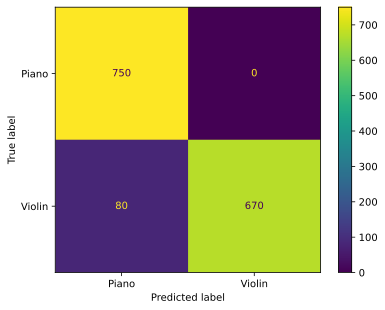

In [18]:
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the classifier: {accuracy:.4f}\n\n")

# Display the classification report
print(classification_report(y_test, y_pred))

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
                       'Piano', 'Violin']).plot()

# Bayes classifier with original audio features

## Inference on training data

In [19]:
x_train_2, y_train_2 = s_d[0], s_d[1]
x_train_2, y_train_2 = shuffle(x_train_2, y_train_2, random_state=42)

print('Total number of samples:', x_train_2.shape[0])
print('Number of features:', x_train_2.shape[1])

Total number of samples: 3000
Number of features: 882


In [20]:
x0_2 = x_train_2[y_train_2 == 0]
x1_2 = x_train_2[y_train_2 == 1]

mu_x0_2 = np.mean(x0_2, axis=0)
mu_x1_2 = np.mean(x1_2, axis=0)

Rx0_2 = np.cov(x0_2.T)
Rx1_2 = np.cov(x1_2.T)

prior0_2 = len(x0_2) / len(x_train_2)
prior1_2 = len(x1_2) / len(x_train_2)

print(f"Mean vector for class 0: {mu_x0_2.shape}")
print(f"Mean vector for class 1: {mu_x1_2.shape}\n")
print(f"Covariance Matrix for class 0: {Rx0_2.shape}")
print(f"Covariance Matrix for class 1: {Rx1_2.shape}\n")
print(f"Prior probability for class 0: {prior0_2}")
print(f"Prior probability for class 1: {prior1_2}")

Mean vector for class 0: (882,)
Mean vector for class 1: (882,)

Covariance Matrix for class 0: (882, 882)
Covariance Matrix for class 1: (882, 882)

Prior probability for class 0: 0.5
Prior probability for class 1: 0.5


In [21]:
# Check if covariance matrices are singular
det_rx0_2 = np.linalg.det(Rx0_2)
det_rx1_2 = np.linalg.det(Rx1_2)

print("Determinant of covariance matrix for class 0:", det_rx0_2)
print("Determinant of covariance matrix for class 1:", det_rx1_2)

if det_rx0_2 == 0 or det_rx1_2 == 0:

    print("\nCovariance matrices are singular. Need to apply PCA.")

    # Get variance preservation ratio from user
    var_ratio = float(
        input("Enter variance preservation ratio (between 0 and 1): "))

    # Apply PCA
    # Automatically determines the number of components
    pca = PCA(n_components=var_ratio, svd_solver='full')
    x_train_pca_2 = pca.fit_transform(x_train_2)

    # Recalculate means and covariances with reduced dimensions
    x0_pca_2 = x_train_pca_2[y_train_2 == 0]
    x1_pca_2 = x_train_pca_2[y_train_2 == 1]

    mu_x0_pca_2 = np.mean(x0_pca_2, axis=0)
    mu_x1_pca_2 = np.mean(x1_pca_2, axis=0)

    Rx0_pca_2 = np.cov(x0_pca_2.T)
    Rx1_pca_2 = np.cov(x1_pca_2.T)

    print(f"\nAfter PCA:")
    print(f"Number of components selected: {pca.n_components_}")
    print(
        f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")
    print(f"New feature dimensions: {x_train_pca_2.shape[1]}")

Determinant of covariance matrix for class 0: 0.0
Determinant of covariance matrix for class 1: 0.0

Covariance matrices are singular. Need to apply PCA.

After PCA:
Number of components selected: 102
Explained variance ratio: 0.9951
New feature dimensions: 102


In [22]:
# Predict the class of the samples
y_pred_2 = np.zeros(x_train_pca_2.shape[0])

for i in range(x_train_pca_2.shape[0]):
    y_pred_2[i] = predict(x_train_pca_2[i], prior0_2, prior1_2,
                        mu_x0_pca_2, mu_x1_pca_2, Rx0_pca_2, Rx1_pca_2)

y_pred_2

array([1., 0., 1., ..., 0., 0., 0.])

Accuracy of the classifier: 0.9743


              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1500
           1       0.96      0.99      0.97      1500

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



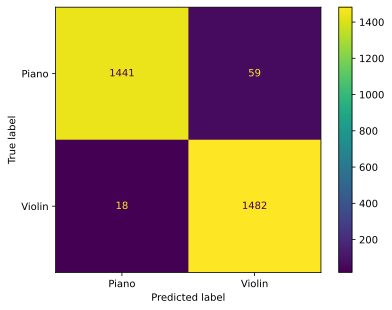

In [23]:
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_train_2, y_pred_2)
print(f"Accuracy of the classifier: {accuracy:.4f}\n\n")

# Display the classification report
print(classification_report(y_train_2, y_pred_2))

# Display the confusion matrix
cm = confusion_matrix(y_train_2, y_pred_2)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
                       'Piano', 'Violin']).plot()

## Inference on test set

In [24]:
sample_audio_test = 'the_godfather_theme_test.wav'
x_test_2, sr = librosa.load(sample_audio_test, sr=44100)

ts_test_2 = Segment(width=samples_per_frame, overlap=0).fit(x_test_2.reshape(1, -1))

s_d_test_2 = ts_test_2.transform(x_test_2.reshape(1, -1))

print('Size of one Vector:', s_d_test[0].shape[1])
print('Number of Test Vectors:', s_d_test[0].shape[0])

Size of one Vector: 882
Number of Test Vectors: 1500


In [25]:
s_d_test_2[0].shape

(1500, 882)

In [26]:
x_test_2 = pca.transform(s_d_test_2[0])
y_test_2 = np.concatenate((np.ones(750), np.zeros(750))) # First half 1s and 2nd half 0, opposite to X_train

In [27]:
# Predict the class of the samples
y_pred_2 = np.zeros(x_test_2.shape[0])

for i in range(x_test_2.shape[0]):
    y_pred_2[i] = predict(x_test_2[i], prior0_2, prior1_2,
                        mu_x0_pca_2, mu_x1_pca_2, Rx0_pca_2, Rx1_pca_2)

y_pred_2

C:\Users\Anirvan Krishna\AppData\Local\Temp\ipykernel_23952\816245241.py:8: RuntimeWarning: invalid value encountered in scalar divide
  posterior0 = (likelihood0 * prior0) / (likelihood0 * prior0 + likelihood1 * prior1)
C:\Users\Anirvan Krishna\AppData\Local\Temp\ipykernel_23952\816245241.py:9: RuntimeWarning: invalid value encountered in scalar divide
  posterior1 = (likelihood1 * prior1) / (likelihood0 * prior0 + likelihood1 * prior1)


array([1., 1., 1., ..., 0., 0., 0.])

Accuracy of the classifier: 0.9467


              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95       750
         1.0       1.00      0.89      0.94       750

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



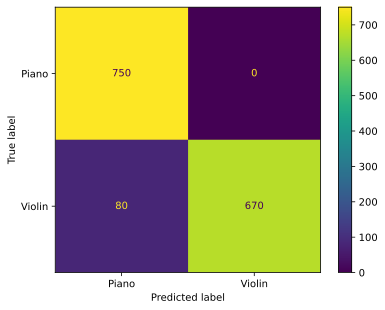

In [28]:
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test_2, y_pred_2)
print(f"Accuracy of the classifier: {accuracy:.4f}\n\n")

# Display the classification report
print(classification_report(y_test_2, y_pred_2))

# Display the confusion matrix
cm = confusion_matrix(y_test_2, y_pred_2)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[
                       'Piano', 'Violin']).plot()